# Models and Machine Learning

The data has been wrangled and thoroughly examined -- now to see if it can be generalized to new data.

## Load in the data and packages

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# See data wrangling report for more details
#load data
spotify = pd.read_csv('../Data/SpotifyFeatures0419.csv')

# Create the sorted dataframe and drop zeros
sort_data = spotify.sort_values('popularity', ascending=False).reset_index()
spotify_ordered = sort_data.drop(['index', 'track_id'], axis=1)
spotify_ordered.index = spotify_ordered.index + 1
spotify_ordered = spotify_ordered[spotify_ordered.popularity > 0]
spotify_ordered[['mode', 'key', 'time_signature']] = \
    spotify_ordered[['mode', 'key', 'time_signature']].astype('category')

In [3]:
#Create table with a column classifying popularity ratings
classified = spotify_ordered.copy()
classified['pop_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity > 50) & (row.popularity < 75):
        score = 'medium'
    elif row.popularity >= 75:
        score = 'popular'
    classified.at[i, 'pop_rating'] = score

<b>Example cases</b><br>
Here I set aside a few use case examples by removing the songs for the following artists: Shakira, Jonas Brothers, Tame Impala, and The Weeknd. This isn't necessarily a test set to verify the model performance after training. A more robust test set will be generated a little further down. This here is just a small set to hopefully help demonstrate the ability of the final model. This is a very small subset of four artists with at least one popular song representing a few different musical genres. The classified dataset is used because it contains both target variables.

In [4]:
artists = ['Shakira', 'Jonas Brothers', 'Tame Impala', 'The Weeknd']

# Create a list of indices corresponding to the artists above
# The first comprehension creates a list of lists, the second flattens it into one
to_drop = [classified[classified.artist_name == name].index.tolist() for name in artists]
to_drop = [ind for sub in to_drop for ind in sub]

# Gather the test cases
df_x = classified.copy()
cases = df_x[df_x.index.isin(to_drop)]

# Remove the test cases from data
classified.drop(to_drop, inplace=True)
spotify_ordered.drop(to_drop, inplace=True)

In [5]:
print(classified.shape)
print(spotify_ordered.shape)

(111762, 17)
(111762, 16)


## Linear Regression
Here I start simple with a basic linear regression model.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set random state
state=25

# Shuffle the data
reg_data = spotify_ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('popularity', axis=1)
y = reg_data.popularity

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

The data has been split into train and test sets, let's see the result out of the box.

In [7]:
# Set the regressor
lr = LinearRegression()

# Fit the train data
lr.fit(X_train, y_train)

# Check the R^2 score
lr.score(X_test, y_test)

0.09785133473998608

The score out of the box is not spectacular. Before delving into the model itself, let's try and improve the data.<br>
<br>
First, we can see what happens when using the categoricals by using one hot encoding with .get_dummies(). For this step, I have decided to drop the artist_name column. While song popularity is often correlated with artist popularity, the hope is for this model to work just as well on an artist it hasn't seen before. Part of the goal is to be able to discover new talent, and that becomes more difficult if the algorithm is inclined to discredit a song just because it doesn't recognize the artist. Therefore, the column will be dropped for training purposes.

In [8]:
no_artist = reg_data.drop(['artist_name', 'track_name'], axis=1)
df_encoded = pd.get_dummies(no_artist)
df_encoded.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_0', 'mode_1', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [9]:
# Do a new split and run a new linear model
XX = df_encoded.drop('popularity', axis=1)
yy = df_encoded.popularity

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=state)

lr_cat = LinearRegression()
lr_cat.fit(X_train, y_train)

print(lr_cat.score(X_test, y_test))

0.0993840543915483


The result is better, but only marginally. To help ensure this result is accurate, cross-validation can be used.

In [10]:
from sklearn.model_selection import cross_val_score

# Use the regressor from above to set up the cross_val
cvals = cross_val_score(lr_cat, XX, yy, cv=6)

# check the results
print(cvals)
print('The mean cross-validatoin score is: {num:.{dig}f}'.format\
      (num=np.mean(cvals), dig=4))

[0.097934   0.10668441 0.09505961 0.095926   0.10660753 0.09992833]
The mean cross-validatoin score is: 0.1004


The results are fairly similar across all of the folds, and the mean score is about the same as all of the previous results. <br>
<br>
This seems to indicate that plain linear regression isn't well suited for this problem, which isn't surprising. Let's try to improve on it using ridge regression.

### Ridge Regression
Trying to improve the model via regularization.

In [11]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train, y_train)

print(ridge.score(X_test, y_test))

0.08705278469931688


This first attempt is worse than basic linear regression, but we can try to improve the result with grid-search cross validation.

In [12]:
from sklearn.model_selection import GridSearchCV

alphas = {'alpha': [0.0005, 0.0006, 0.00075, 0.0009, 0.001]}

rg = Ridge(normalize=True)

rg_cv = GridSearchCV(rg, alphas, cv=6)

rg_cv.fit(XX, yy)

print(rg_cv.best_params_)
print(rg_cv.best_score_)

{'alpha': 0.00075}
0.10035685624500996


The result improved, but now it's basically the same as linear regression.

<b>Plotting actual versus predicted values</b><br>
The plot below might give a clue as to why the linear models are performing so poorly. The range of predicted values is much narrower than the actual popularity values. This makes sense when thinking about linear regressions and the plots from the data story report: the prediction is a single line through a cloud of observations, which is similar to the plot below.

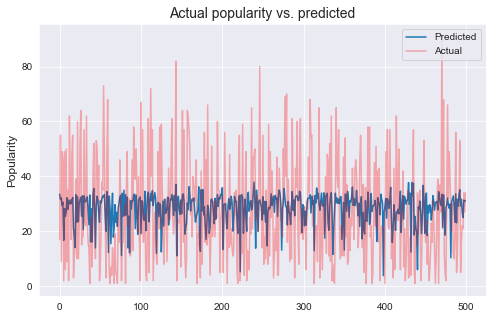

In [13]:
fig = plt.subplots(figsize=(8,5))
_ = plt.plot(list(lr_cat.predict(X_test))[:500], label='Predicted')
_ = plt.plot(list(y_test)[:500], c='r', alpha=0.3, label='Actual')
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Popularity', fontsize=12)
_ = plt.title('Actual popularity vs. predicted', fontsize=14)

## Classification

Because the regression models are not getting the job done, the next step is to use the `classified` dataset and try a classification approach.

<b>Class imbalance</b><br>
Before jumping into the process of training a classification model, the class imbalance needs to first be addressed. The disparity can be seen here.

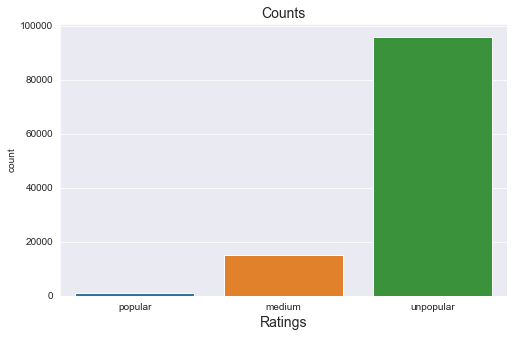

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = sns.countplot(x='pop_rating', data=classified)
_ = plt.xlabel('Ratings', fontsize=14)
_ = plt.title('Counts', fontsize=14)

##### Creating a balanced sample for the final test set
Instead of using a random sample for the final test set, here I manually create the test set in order to preserve the ratios of the labels.<br>
<br>
First, as before with the encoded dataframe from the regression model, I drop the `artist_name` column, along with `track_name`, and convert the categorical variables.

In [15]:
df = classified.drop(['artist_name', 'track_name'], axis=1)
df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])
df.shape

(111762, 31)

Next, I create a separate dataframe with all the observations for each label, and then split each of those into train and test splits. All of the training splits and then all of the test splits are then stitched together so that all labels are represented in the data.

In [16]:
from sklearn.model_selection import train_test_split

df_pop = df[df.pop_rating == 'popular']

df_med = df[df.pop_rating == 'medium']

df_unpop = df[df.pop_rating == 'unpopular']

# Set random seed
state=25

X_tr_p, X_ts_p, y_tr_p, y_ts_p = train_test_split(df_pop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_pop.pop_rating, test_size=0.15, random_state=state)

X_tr_m, X_ts_m, y_tr_m, y_ts_m = train_test_split(df_med.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_med.pop_rating, test_size=0.15, random_state=state)

X_tr_up, X_ts_up, y_tr_up, y_ts_up = train_test_split(df_unpop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_unpop.pop_rating, test_size=0.15, random_state=state)

Here the training splits are merged to form one training set, and then reshuffled to randomize the data. The output shows the shape of the training set.

In [17]:
pop_train = pd.concat([X_tr_p, y_tr_p], axis=1)
med_train = pd.concat([X_tr_m, y_tr_m], axis=1)
unpop_train = pd.concat([X_tr_up, y_tr_up], axis=1)

training = pd.concat([pop_train, med_train, unpop_train], axis=0)

training = training.sample(frac=1, random_state=state).reset_index(drop=True)

# Popularity has been removed, so only 30 columns
training.shape

(94997, 30)

The same process above is now executed with the final test data.

In [18]:
pop_test = pd.concat([X_ts_p, y_ts_p], axis=1)
med_test = pd.concat([X_ts_m, y_ts_m], axis=1)
unpop_test = pd.concat([X_ts_up, y_ts_up], axis=1)

final_test = pd.concat([pop_test, med_test, unpop_test], axis=0)

final_test = final_test.sample(frac=1, random_state=state).reset_index(drop=True)

final_test.shape

(16765, 30)

Now we have a training set of about 95,000 observations, stored as `training`, and a test set of about 16,800 rows, stored as `final_test`. With the data split, we can now train the models using the training data.

<b> Train and validation sets</b><br>
Before actually diving into the models, the training data needs to be further split into training and validation sets to allow testing without using the final test set.

In [19]:
X_class = training.drop('pop_rating', axis=1)
y_class = training.pop_rating

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.25, random_state=state)

#### Decision Tree
Before getting into complex ensemble methods, let's first try a simple decision tree.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Basic decision tree
dt = DecisionTreeClassifier(max_depth=20, random_state=state)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(accuracy_score(pred, y_test))

0.7930105263157895


The accuracy score for the first try isn't bad. Now, I know that accuracy doesn't always tell the full story, especially with imbalanced data, but it's a good basic assessment to use while trying out the models before diving into precision and recall. With that in mind, let's try some parameter tuning in order to improve the accuracy.

In [30]:
params = {'max_depth': [2, 10, 20, 40, 50],
         'min_samples_leaf': np.arange(1,10,2),}

dt = DecisionTreeClassifier(random_state=state)

dt_cv = GridSearchCV(dt, params, cv=6)

dt_cv.fit(X_class, y_class)

print(dt_cv.best_params_)
print(dt_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 1}
0.8571218038464372


Adjusting the params grid to re-test the edges.

In [31]:
params = {'max_depth': [2, 3, 4],
         'min_samples_leaf': np.arange(1,4)}

dt_cv = GridSearchCV(dt, params, cv=6)

dt_cv.fit(X_class, y_class)

print(dt_cv.best_params_)
print(dt_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 1}
0.8571218038464372


#### Bagging
The decision tree model seems to have maxed out, so let's try increasing the complexity by using bagging.

In [37]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=state)
bc = BaggingClassifier(base_estimator=tree, n_estimators=200, random_state=state)

bc.fit(X_train, y_train)

b_pred = bc.predict(X_test)

print(accuracy_score(b_pred, y_test))

0.8585263157894737


The improvement is marginal. Instead of spending a lot of time trying to tweak the base estimator to try and improve this model, I think it would be a better use of time to move to a different model.

#### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=state)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8606736842105264


Getting closer. Let's do some fine tuning via grid-search cross validation.

In [39]:
rf_params = {'n_estimators': [100, 300, 500],
            'max_depth': [2, 5, 20, 100],
            'min_samples_leaf': [1, 2, 5]}

rf_new = RandomForestClassifier(random_state=state)

rf_cv = GridSearchCV(rf_new, rf_params, n_jobs=-1, cv=6)

rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)

{'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 300}


Now run it with the updated parameters.

In [40]:
rf = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1, random_state=state)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8608421052631579


The increase in accuracy is negligible. 

#### Boosting
Let's also try boosting to see if the model improves when running sequentially.

In [50]:
%%time

from sklearn.ensemble import AdaBoostClassifier

dt_b = DecisionTreeClassifier(max_depth=1, random_state=state)

adb = AdaBoostClassifier(base_estimator=dt_b, n_estimators=200)

adb.fit(X_train, y_train)

adb_pred = adb.predict(X_test)

print(accuracy_score(adb_pred, y_test))

0.8584421052631579
Wall time: 30.4 s


In [52]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=state)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print(accuracy_score(gb_pred, y_test))

0.8581894736842105
Wall time: 50.9 s


The results are more or less the same with AdaBoost and gradient boosting, and are a slight down grade from random forest.<br>
<br>
The accuracy seems to have plateaued, so it's time to dig in to some other metrics.

#### Confusion matrix
More important than plain accuracy, the real value of this project is the ability to predict popular songs. This can be tested through a confusion matrix.

In [54]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gb_pred)

array([[    7,     2,  3133],
       [    0,     0,   218],
       [    6,     9, 20375]], dtype=int64)

For the gradient boosting model, the result is pretty poor. The minority class, popularity, had zero true positives. Even with a decent accuracy, the model really failed in its true purpose.

In [55]:
confusion_matrix(y_test, rf_pred)

array([[   69,     0,  3073],
       [    4,     5,   209],
       [   16,     3, 20371]], dtype=int64)

The matrix for random forest is a bit better but not by much.

In [56]:
confusion_matrix(y_test, adb_pred)

array([[    0,     0,  3142],
       [    0,     0,   218],
       [    2,     0, 20388]], dtype=int64)

The AdaBoost model pretty much predicted everything as unpopular.<br>
<br>
The random forest model seems to have performed the best of all the models tried.

#### Class weights
Let's see if we can make some improvements by adjusting the weights applied to the class labels. By applying larger weights to the minority classes, the idea is that the model will give those labels more emphasis. This way, we can direct the model to focus more on producing true positives for the class of interest.<br>
I will first apply this to the bagging model to see if any improvements are made.

In [59]:
dt_bal = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=state)
bc_bal = BaggingClassifier(base_estimator=dt_bal, n_estimators=200)

bc_bal.fit(X_train, y_train)

bcb_p = bc_bal.predict(X_test)

print(accuracy_score(bcb_p, y_test))


0.4744842105263158


In [60]:
confusion_matrix(y_test, bcb_p)

array([[  664,  1602,   876],
       [   48,   149,    21],
       [ 3262,  6672, 10456]], dtype=int64)

Re-running bagging with balanced weights, the accuracy is much worse, but the recall is greatly improved. Encouraginly, the majority of the popular songs were predicted correctly, which is most important. Unfortunately, there are 6600 false positives from the unpopular class to sift through now.

In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bcb_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.17      0.21      0.19      3142
     popular       0.02      0.68      0.03       218
   unpopular       0.92      0.51      0.66     20390

   micro avg       0.47      0.47      0.47     23750
   macro avg       0.37      0.47      0.29     23750
weighted avg       0.81      0.47      0.59     23750



Using the above chart helps understand how well the model really worked. Of the 218 popular observations, 149 were correctly for a recall of 68%. However, of the thousands of observations predicted as popular, only 149 truly were, leading to a precision of only 2% and an F1-score of only 0.03. <br>
<br>
Let's re-run random forest and AdaBoost now with the balanced weights to see if further improvement is possible.

In [82]:
from sklearn.utils import class_weight
class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

array([ 2.47540129, 38.36672052,  0.38911099])

Try overcompensating the weight for the popular label.

In [78]:
rf_b = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1,\
                            class_weight={'medium': 2.475, 'popular': 100, 'unpopular': 1}, random_state=state)

rf_b.fit(X_train, y_train)

rfb_p = rf_b.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8608421052631579


In [80]:
print(confusion_matrix(y_test, rfb_p))

[[   66     0  3076]
 [    4     5   209]
 [   15     1 20374]]


In [81]:
print(classification_report(y_test, rfb_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.78      0.02      0.04      3142
     popular       0.83      0.02      0.04       218
   unpopular       0.86      1.00      0.93     20390

   micro avg       0.86      0.86      0.86     23750
   macro avg       0.82      0.35      0.34     23750
weighted avg       0.85      0.86      0.80     23750



Less than ideal results. The confusion matrix has shifted back towards higher precision at the cost of predicting fewer popular songs correctly.<br>
<br>
Now with boosting.

In [89]:
dt_bal = DecisionTreeClassifier(max_depth=2,\
                                class_weight={'medium': 2.475, 'popular': 150, 'unpopular': 1},\
                                random_state=state)

ad_bal = AdaBoostClassifier(base_estimator=dt_bal, n_estimators=200)

ad_bal.fit(X_train, y_train)

ad_bal_p = ad_bal.predict(X_test)

print(accuracy_score(ad_bal_p, y_test))

0.7551578947368421


In [90]:
confusion_matrix(y_test, ad_bal_p)

array([[  210,   665,  2267],
       [   20,    86,   112],
       [  675,  2076, 17639]], dtype=int64)

In [91]:
print(classification_report(y_test, ad_bal_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.23      0.07      0.10      3142
     popular       0.03      0.39      0.06       218
   unpopular       0.88      0.87      0.87     20390

   micro avg       0.76      0.76      0.76     23750
   macro avg       0.38      0.44      0.34     23750
weighted avg       0.79      0.76      0.76     23750



These results are a little better than the ones for random forest, but it would be nice if the model predicted more popular songs. <br>
<br>
We could continue playing with the class weights to try and improve the F1-score, but as it stands now, I think the bagging model best achieves it's goal. It's ultimately up to the stake holder, but the fact that the bagging model does the best at predicting popular songs is key, in my opinion. The performance likely isn't ideal, but for someone trying to sift through songs to pick out the best candidates, it's better to have to deal with only a few thousand as opposed to tens of thousands. Also, if the new batch of songs to comb through is only in the hundreds, then narrowing that down by 80-90% makes the task quite manageable.